<a href="https://colab.research.google.com/github/WeyoriJoshua/Projects/blob/main/98_RICE_CROP_DIESEASE_PREDICTION_USING_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Enable memory growth for the GPU
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)


In [3]:
# Directory containing the dataset
base_dir = '/content/drive/MyDrive/Rice Crop Dataset'
categories = ['Rice__Bacterialblight', 'Rice__Blast', 'Rice__Brownspot', 'Rice__Healthy']

In [4]:
# Load dataset
def load_images(base_dir, categories, img_size=(128, 128)):
    images = []
    labels = []
    for category in categories:
        category_path = os.path.join(base_dir, category)
        for filename in os.listdir(category_path):
            if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
                img_path = os.path.join(category_path, filename)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(category)
    return np.array(images), np.array(labels)

images, labels = load_images(base_dir, categories)

In [5]:
# Display sample images
def display_sample_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        idx = np.random.randint(len(images))
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx])
        plt.title(class_names[labels[idx]])
        plt.axis('off')
    plt.show()

In [6]:
# Data Preprocessing
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded)

In [7]:

# Normalize images
images = images / 255.0

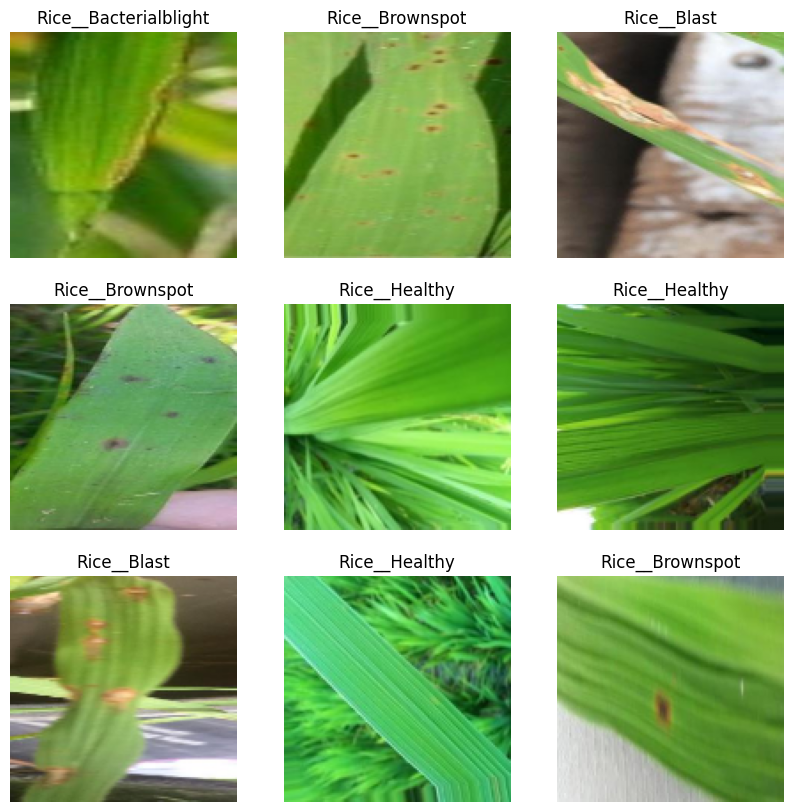

In [8]:
class_names = le.classes_
display_sample_images(images, labels_encoded.argmax(axis=1), class_names)

In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

In [10]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [11]:
# Load pre-trained VGG16 model and add custom layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model = Sequential()
model.add(vgg_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()

# Convolutional Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  # Moderate dropout for regularization

# Convolutional Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))  # Slightly higher dropout

# Convolutional Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))  # Increased dropout

# Classification Layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))  # Larger fully connected layer
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Higher dropout before output
model.add(Dense(len(categories), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.add(Dense(len(categories), activation='softmax'))

In [14]:
# Train the model with callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=120,
                    callbacks=[early_stopping, reduce_lr])


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 337ms/step - accuracy: 0.6095 - loss: 1.1030 - val_accuracy: 0.3767 - val_loss: 1.3706 - learning_rate: 0.0010
Epoch 2/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - accuracy: 0.6859 - loss: 1.0044 - val_accuracy: 0.2956 - val_loss: 1.3250 - learning_rate: 0.0010
Epoch 3/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.7315 - loss: 0.9321 - val_accuracy: 0.6044 - val_loss: 1.0848 - learning_rate: 0.0010
Epoch 4/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - accuracy: 0.7674 - loss: 0.8601 - val_accuracy: 0.6333 - val_loss: 1.0678 - learning_rate: 0.0010
Epoch 5/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 169ms/step - accuracy: 0.7611 - loss: 0.8476 - val_accuracy: 0.4656 - val_loss: 1.1560 - learning_rate: 0.0010
Epoch 6/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 0.7581 - loss: 0.8183 - val_accuracy: 0.6300 - val_loss: 0.9600 - learning_rate: 0.0010
Epoch 7/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accura

In [15]:

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9891 - loss: 0.0912
Test Accuracy: 98.89%


In [16]:
# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


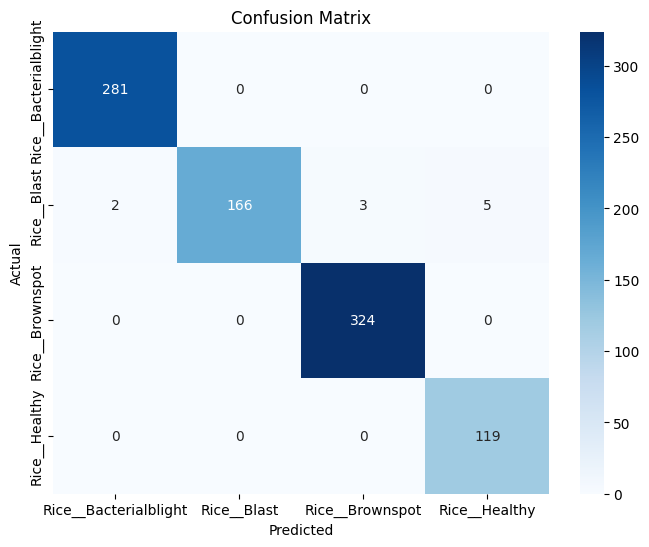

In [17]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
 # Classification Report
class_report = classification_report(y_true, y_pred_classes, target_names=class_names)
print('Classification Report:')
print(class_report)


Classification Report:
                       precision    recall  f1-score   support

Rice__Bacterialblight       0.99      1.00      1.00       281
          Rice__Blast       1.00      0.94      0.97       176
      Rice__Brownspot       0.99      1.00      1.00       324
        Rice__Healthy       0.96      1.00      0.98       119

             accuracy                           0.99       900
            macro avg       0.99      0.99      0.99       900
         weighted avg       0.99      0.99      0.99       900



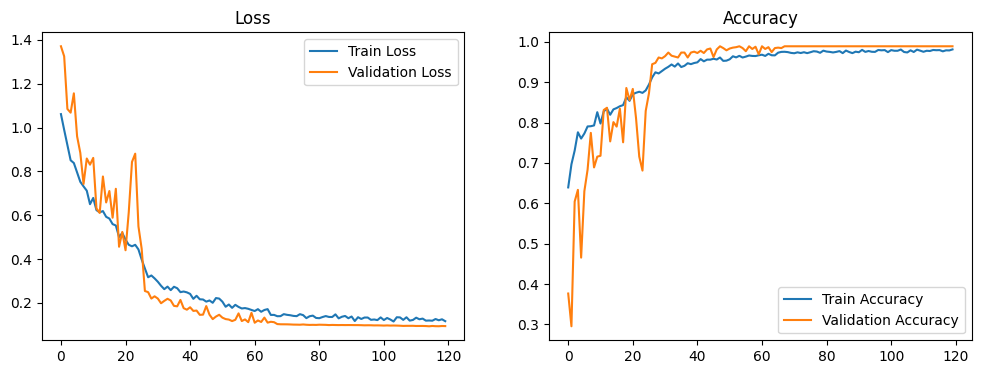

In [19]:

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [20]:
# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9891 - loss: 0.0912
Test Accuracy: 98.89%


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('rice_disease_classifier.tflite', 'wb') as f:
  f.write(tflite_model)

In [22]:
# Assuming test_gen is your test data generator, get the number of samples in the test set
# ... (Rest of your existing code) ...

# Define data generators for training, validation, and testing sets
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator()  # No augmentation for validation and test

test_datagen = ImageDataGenerator()

# Create data generators for training, validation, and test sets
train_gen = train_datagen.flow(X_train, y_train, batch_size=32)
valid_gen = valid_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)  # shuffle=False for evaluation
test_gen = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)  # shuffle=False for evaluation


#Instead of using test_gen.filenames which is causing the error, we'll use the shape of X_test to determine the number of samples
ts_length = X_test.shape[0]
# Calculate the batch size for the test set
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
# Calculate the number of steps for the test set
test_steps = ts_length // test_batch_size

# Evaluate the model on the training, validation, and test sets
train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

# Print the evaluation results
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9871 - loss: 0.1007
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9885 - loss: 0.0925
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9885 - loss: 0.0925
Train Loss:  0.0962730273604393
Train Accuracy:  0.9895833134651184
--------------------
Validation Loss:  0.08300826698541641
Validation Accuracy:  0.9921875
--------------------
Test Loss:  0.08300826698541641
Test Accuracy:  0.9921875


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already calculated train_score, valid_score, and test_score

# Create a dictionary to store the metrics
metrics_data = {
    'Dataset': ['Train', 'Validation', 'Test'],
    'Loss': [train_score[0], valid_score[0], test_score[0]],
    'Accuracy': [train_score[1], valid_score[1], test_score[1]]
}

# Create a pandas DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_data)

# Display the table
print(metrics_df.to_string(index=False))  # index=False to hide the index column


# Create graphs for Loss and Accuracy
plt.figure(figsize=(12, 4))

# Loss Graph
plt.subplot(1, 2, 1)
sns.barplot(x='Dataset', y='Loss', data=metrics_df)
plt.title('Loss Comparison')

# Accuracy Graph
plt.subplot(1, 2, 2)
sns.barplot(x='Dataset', y='Accuracy', data=metrics_df)
plt.title('Accuracy Comparison')

plt.tight_layout()
plt.show()

In [ ]:

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [ ]:
from tensorflow.keras.models import load_model
import h5py
model.save("rice_disease_model.h5")#Save the model itself and not the weights. This can be converted to TFLite
model.save_weights("rice_disease_model_weights.weights.h5")   #Save the model weights. This cannot be converted to TFLite

print("Saved model to disk")
#If you get the following error: ImportError: DLL load failed while importing _errors: The specified procedure could not be found.
#Run pip install h5py==3.9.0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have X_test, y_test, and class_names defined

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Display some predictions
plt.figure(figsize=(10, 10))
for i in range(9):  # Display 9 images
    idx = np.random.randint(len(X_test))
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"Predicted: {class_names[y_pred_classes[idx]]}\nActual: {class_names[y_true[idx]]}")
    plt.axis('off')

plt.show()

In [27]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable dynamic range quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('rice_disease_classifier_quantized.tflite', 'wb') as f:
  f.write(tflite_model)

print("Quantized model saved to: rice_disease_classifier_quantized.tflite")

Saved artifact at '/tmp/tmpaxg2zmok'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_34')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139345559730704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139345559731472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139345160942800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139345160942224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139345559730512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139345160941648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139345160943184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139345160944528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139345160943952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139345160945488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13934516094